In [1]:
### import numpy as np 
import pandas as pd
import allel
import malariagen_data
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
%run hapclust.py

In [2]:
def clustersToFrequencies(transcript, cluster_spans, geno, pos, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    probe.log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
        
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(snps, pos, transcript, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set", dendro_only=False, metaquery=None):
    
    probe.log("Remapping haplotype alleles to match snp effect data...")   
    haplos = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
    haplos, pos = remap_haplo_alleles(haplos=haplos, haplo_pos=pos, transcript=transcript, metaquery=metaquery)
        
    probe.log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150, label_clusters=False)
    plt.show()
    
    probe.log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort, leaves)
    
    
def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(transcript, sample_sets=sample_set, analysis='gamb_colu_arab')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = ag3.sample_metadata(cohorts)
        meta = meta.query(metaquery)
        sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
        snps = snps.isel(samples=sample_bool)

    probe.log(f"{sample_set}, query={metaquery}, cohort_size : {snps['call_genotype'].shape[1]}")

    df_af, coh, leaves = TranscriptSweptAlleleFreqs(snps, allel.SortedIndex(snps['variant_position']), transcript, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set, metaquery=metaquery)  
    return(df_af, coh, leaves)

def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            ac_coh = gt_coh.count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)
    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    )
    pos_bool = np.isin(df_effects['position'], pos)
    df_effects = df_effects[pos_bool]
    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)
    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps)


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df[key] - df.filter(regex="wt").iloc[:,0]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'] > 0.4]['aa_change'] #.abs() used if we want aa reversion to show on signature
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"
        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

def remap_haplo_alleles(haplos, haplo_pos, transcript, metaquery):
    """
    Because haplotypes are coded 0,1, but genotypes 0-3, 1s in the haplotype may refer to different ALTs in the genotype array. This
    causes a problem when using ag3.snp_effects() to fit alleles to their aa change, therefore, we need to recode alleles back to the correct
    ALT
    """
    # Load genotype data - needed to find correct ALT for each SNP
    geno = allel.GenotypeDaskArray(ag3.snp_genotypes(region=transcript, sample_sets=cohorts))
    meta = ag3.sample_metadata(cohorts)
    if metaquery != None:
        meta = meta.query(metaquery)
    geno = geno.take(meta.index.to_list(), axis=1)
    geno_pos = allel.SortedIndex(ag3.snp_sites(region=transcript, field='POS').compute())
    
    # find intersection between haplotype positions and genotypes 
    geno_mask, hap_mask = geno_pos.locate_intersection(haplo_pos)
    geno = geno.compress(geno_mask, axis=0)
    ac = geno.count_alleles().compute()
    
    # remove multiallelics, there shouldnt be any in here?
    multiallele_mask = (ac > 0).sum(axis=1) > 2
    ac = ac[~multiallele_mask]
    # find appropriate allele
    mappings = np.argmax(ac[:,1:], axis=1) + 1
    # make mapping array for scikit-allel
    zeros = np.zeros(len(mappings))
    mapping = np.vstack([zeros, mappings]).T
    
    # Remap!
    haplos = haplos[~multiallele_mask].map_alleles(mapping)
    haplo_pos  = haplo_pos[~multiallele_mask]
       
    return(haplos, haplo_pos)

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

def load_metahaps(cohorts, names, metaquery = None):
    meta = ag3.sample_metadata(cohorts)
    meta = meta.query("sample_id in @names")
    meta.loc[:, 'sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
    if metaquery != None: 
        query_bool = meta.eval(metaquery)
        meta = meta.query(metaquery)
    meta = meta.sort_values(by='sample_id')
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    if metaquery == None:
        return(metahaps, np.repeat(True, meta.shape[0]))
    else:
        return(metahaps, query_bool)

def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")
    
def haplotypes_to_aa_pandas(haps_xarray, snpdf, myquery="max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'", reverse=False, metaquery= None):
    #Subset the data to all aa changes above 5% frequency
    aa_snps = snpdf.query(myquery)['position'].to_list()
    pos_bool = allel.SortedIndex(haps_xarray['variant_position'].values).locate_intersection(aa_snps)[0]
    print(f"There are {len(aa_snps)} amino acid changes with {myquery}")
    
    metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)
    haps2 = allel.GenotypeArray(haps_xarray['call_genotype'].isel(variants=pos_bool, samples=query_bool).compute()).to_haplotypes()
    
    haps_df = pd.DataFrame(haps2)
    haps_df.loc[:, 'aa_change'] = snpdf.query(myquery).reset_index()['aa_change']
    haps_df = haps_df.set_index('aa_change')
    haps_df = haps_df.iloc[::-1] if reverse == True else haps_df # only if reverse strand like AGAP006227
    return(haps_df) # can only run once!

def rename_duplicates(old):
    seen = {}
    for x in old:
        if x in seen:
            seen[x] += 1
            yield "%s_%d" % (x, seen[x])
        else:
            seen[x] = 0
            yield "%s_%d" % (x, seen[x])

## coeae1f haplotype tagging snps

In [3]:
cohorts = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    # Amenta-Etego sample sets in Ag3.3
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]


contig= '2L'
coeregion = '2L:28520000-28580000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

Load sample metadata:   0%|          | 0/12 [00:00<?, ?it/s]

['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-TZ', '1244-VO-GH-YAWSON-VMF00149', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=None, cohort_size : 2431
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


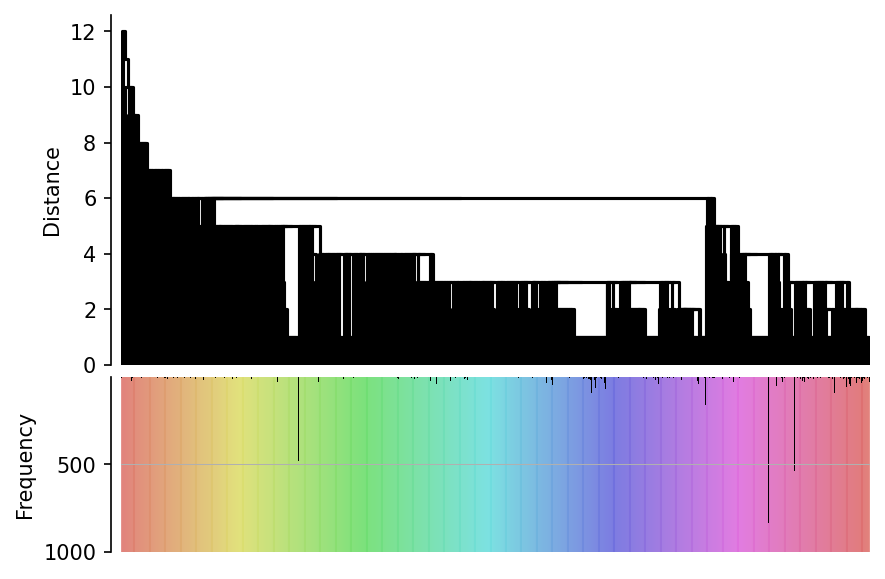

Finding allele frequencies from cluster indices
There are 8 clusters with [478, 89, 71, 160, 832, 539, 92, 2601]


In [5]:
ag3 = malariagen_data.Ag3(pre=True)

snpdf_227, coho, leav = phase3cluster(cohorts, "AGAP006227-RA", contig, cut=1, t=0, min_cohort_size=70, metaquery=None) #"aim_species == 'gambiae'")

#### Load haplotype data and store sweep cluster assignment

In [6]:
metaquery = None

snps = ag3.haplotypes(region=coeregion, sample_sets=cohorts, analysis='gamb_colu_arab')
names = snps['sample_id'].values
pos = allel.SortedIndex(snps['variant_position'])
metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)

for k,v in coho.items():
    for idx in v:
        metahaps.loc[idx, 'sweep_cluster'] = k

metahaps.loc[:, 'sample_id'] = [i for i in rename_duplicates(metahaps['sample_id'])]
metahaps.loc[:, 'sweep_id'] = pd.factorize(metahaps['sweep_cluster'])[0]
metahaps.loc[:, 'sweep_id'][metahaps['sweep_id'] == 0] = "wt"

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Subset to segregating sites

In [7]:
geno = allel.GenotypeArray(snps['call_genotype'])
ac = geno.count_alleles()
seg = ac.is_segregating()
geno = geno.compress(seg, axis=0)
pos = pos[seg]
geno.shape

(11481, 2431, 2)

#### Load sklearn libraries and define function to find tag snps

In [8]:
from yellowbrick.model_selection import RFECV

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report
#from sklearn.feature_selection import RFECV

def find_haplotype_tags(wt_haps, sweep_haps, pos, model, test_size_ratio=0.2, total_required_tags=5, rfecv=True):
    """
    Take two haplotype arrays and train a random forest that uses SNPs to predict the status of a haplotype (swept or wt)
    to identify haplotype tagging SNPs
    """
    if rfecv == False :print(f"Using a {model} regression to identify haplotype tagging SNPs \n")
    
    wt_haps_t = np.transpose(wt_haps)
    sw_haps_t = np.transpose(sweep_haps)
    
    #split into train and test set
    wt_train, wt_test = train_test_split(wt_haps_t, test_size=test_size_ratio)
    sw_train, sw_test = train_test_split(sw_haps_t, test_size=test_size_ratio)

    #make phenotype binary indicator
    wt = np.zeros(len(wt_train), dtype=np.int16)
    sw = np.ones(len(sw_train), dtype=np.int16)
    sw_wt_bin = np.append(sw,wt)
    cluster_train = np.concatenate((sw_train, wt_train), axis=0)
    if rfecv == False: print("How many individuals in the training set?", len(cluster_train)) 
    
    wtt = np.zeros(len(wt_test), dtype=np.int16)
    swt = np.ones(len(sw_test), dtype=np.int16)
    swtt = np.append(swt, wtt)
    swt_test = np.concatenate((sw_test, wt_test), axis=0)
    if rfecv == False: print("How many individuals in the test set?:" ,len(swt_test))
    
    if model == 'random_forest':
        clf = RandomForestClassifier(n_jobs=2, bootstrap = True)
        clf.fit(cluster_train, sw_wt_bin) 
        pred = clf.predict(swt_test)
    elif model == 'lasso':
        clf = LogisticRegression(penalty='l1', solver='liblinear')
        clf.fit(cluster_train, sw_wt_bin) 
        pred = clf.predict(swt_test)
    
    if rfecv == False: print(f"{model} accuracy on the training data:", accuracy_score(sw_wt_bin, clf.predict(cluster_train)))
    if rfecv == False: print(f"{model} accuracy on the test data:" , accuracy_score(swtt, pred))
    #confusion = confusion_matrix(swtt, pred)
    #print("confusion matrix:" , confusion)
    if rfecv == False: print(classification_report(swtt, pred))
    #scores = cross_val_score(clf, swt_test, swtt, cv=5)
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    if model == 'random_forest':
        importances = clf.feature_importances_
        important_feature = importances[importances > 0000000000.1]
        if rfecv == False: print("How many snps is the random forest using to make the classification?:", len(important_feature))
        important_feature_01 = importances[importances > 0.01]
        if rfecv == False: print("How many snps have an importance above 1%?:", len(important_feature_01))
    elif model == 'lasso':
        importances = clf.coef_[0]
           
    # make df of features (snps)
    model_positions = pd.DataFrame({'importance': importances, 
                                 'positions': list(pos)}, 
                                columns=['importance', 'positions']).sort_values('importance',ascending=False)
    
    if rfecv == True:
        print("Running feature selection algorithm")
        selector = RFECV(clf, step=1, cv=5, min_features_to_select=total_required_tags)
        selector = selector.fit(cluster_train, sw_wt_bin)
        #print("Cross-validating...")
       # scores = cross_val_score(selector, swt_test, swtt, cv=5)
        #print(f"Accuracy with {total_required_tags} hap tags: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        selector.show()
        return(model_positions, selector)
    
    return(model_positions)

#### Loop through sweep clusters and find hap tagging SNPs

-------------------------------------- n=478 | E477V --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 2326
How many individuals in the test set?: 583
random_forest accuracy on the training data: 0.9028374892519346
random_forest accuracy on the test data: 0.855917667238422
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       487
           1       0.55      0.72      0.62        96

    accuracy                           0.86       583
   macro avg       0.74      0.80      0.77       583
weighted avg       0.88      0.86      0.86       583

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 23
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


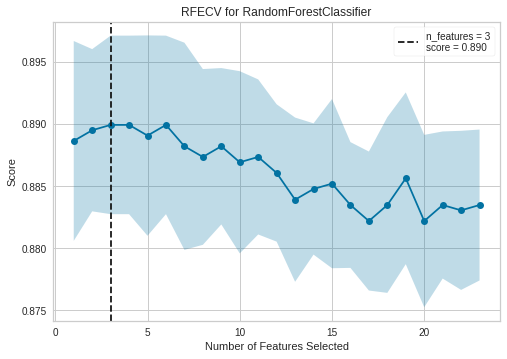



-------------------------------------- n=89 | D463N,T390M,V90L --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 2015
How many individuals in the test set?: 505
random_forest accuracy on the training data: 0.9667493796526054
random_forest accuracy on the test data: 0.9564356435643564
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       487
           1       0.17      0.06      0.08        18

    accuracy                           0.96       505
   macro avg       0.57      0.52      0.53       505
weighted avg       0.94      0.96      0.95       505

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 26
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


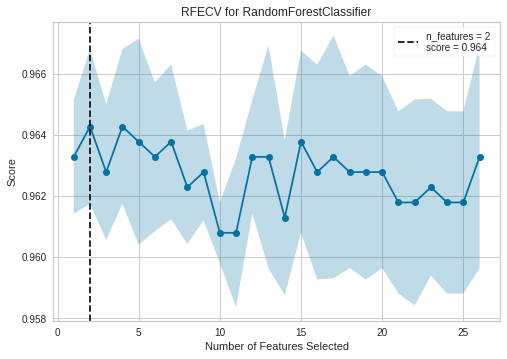



-------------------------------------- n=71 | D463N --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 2000
How many individuals in the test set?: 502
random_forest accuracy on the training data: 0.9805
random_forest accuracy on the test data: 0.9601593625498008
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       487
           1       0.31      0.27      0.29        15

    accuracy                           0.96       502
   macro avg       0.64      0.62      0.63       502
weighted avg       0.96      0.96      0.96       502

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 3
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


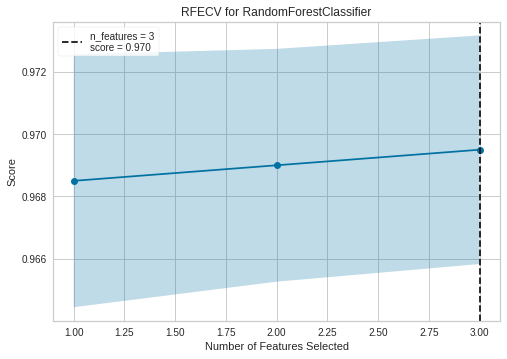



-------------------------------------- n=160 | R173H,E28V --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 2072
How many individuals in the test set?: 519
random_forest accuracy on the training data: 0.9821428571428571
random_forest accuracy on the test data: 0.9421965317919075
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       487
           1       0.53      0.56      0.55        32

    accuracy                           0.94       519
   macro avg       0.75      0.76      0.76       519
weighted avg       0.94      0.94      0.94       519

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 22
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


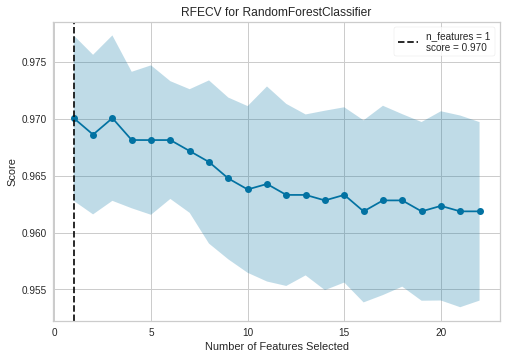



-------------------------------------- n=832 |  --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 2609
How many individuals in the test set?: 654
random_forest accuracy on the training data: 0.9417401303181295
random_forest accuracy on the test data: 0.9143730886850153
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       487
           1       0.78      0.92      0.85       167

    accuracy                           0.91       654
   macro avg       0.88      0.92      0.89       654
weighted avg       0.92      0.91      0.92       654

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 25
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


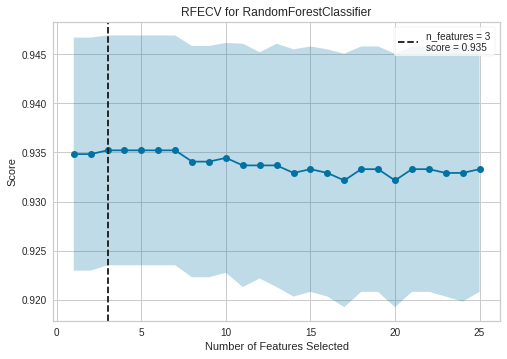



-------------------------------------- n=539 |  --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 2375
How many individuals in the test set?: 595
random_forest accuracy on the training data: 0.9646315789473684
random_forest accuracy on the test data: 0.9327731092436975
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       487
           1       0.78      0.88      0.83       108

    accuracy                           0.93       595
   macro avg       0.88      0.91      0.89       595
weighted avg       0.94      0.93      0.93       595

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 24
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


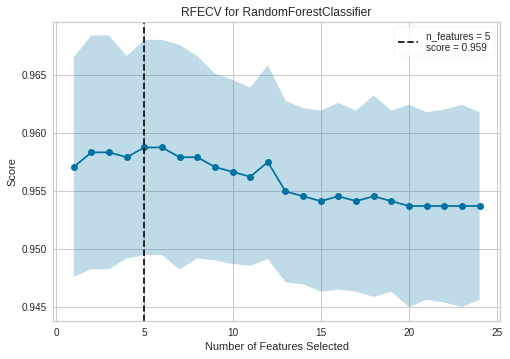



-------------------------------------- n=92 |  --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 2017
How many individuals in the test set?: 506
random_forest accuracy on the training data: 0.9960337134357957
random_forest accuracy on the test data: 0.9901185770750988
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       487
           1       0.82      0.95      0.88        19

    accuracy                           0.99       506
   macro avg       0.91      0.97      0.94       506
weighted avg       0.99      0.99      0.99       506

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 25
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


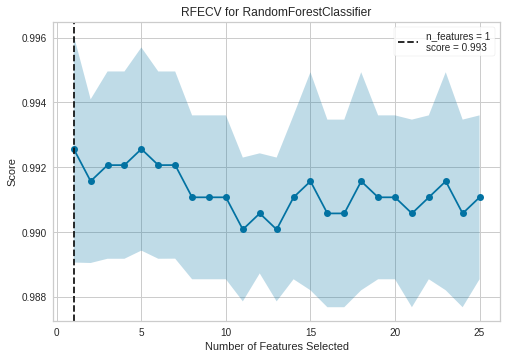



-------------------------------------- wt n=2601 --------------------------------------
Using a random_forest regression to identify haplotype tagging SNPs 

How many individuals in the training set? 4024
How many individuals in the test set?: 1008
random_forest accuracy on the training data: 0.7395626242544732
random_forest accuracy on the test data: 0.4583333333333333
              precision    recall  f1-score   support

           0       0.43      0.40      0.42       487
           1       0.48      0.51      0.49       521

    accuracy                           0.46      1008
   macro avg       0.46      0.46      0.46      1008
weighted avg       0.46      0.46      0.46      1008

How many snps is the random forest using to make the classification?: 0
How many snps have an importance above 1%?: 2
----------------------------- Recursive feature elimination -------------------------------
Running feature selection algorithm


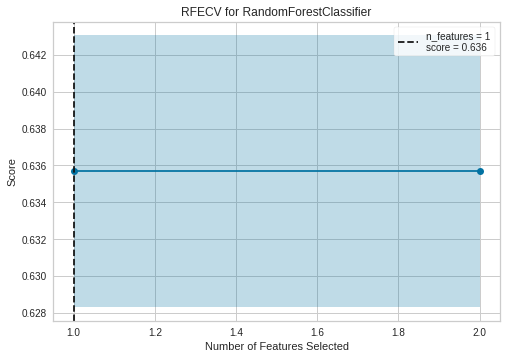

In [16]:
model = 'random_forest' #'random_forest'

feat_selector = {}
coefs = {}
for sweep, sw_idx in coho.items():
                                             
    sweep_haps = geno.to_haplotypes().take(sw_idx, axis=1)
    wt_idx = np.setdiff1d(np.arange(geno.shape[1]), idx)
    wt_haps = geno.to_haplotypes().take(wt_idx, axis=1)
    
    print("--------------------------------------", sweep, "--------------------------------------")
    coefs[sweep] = find_haplotype_tags(wt_haps=wt_haps, 
                                                             sweep_haps=sweep_haps, 
                                                             pos=pos, 
                                                             model=model, 
                                                             test_size_ratio=0.2,
                                                            total_required_tags=None, rfecv=False)

    informative_pos = coefs[sweep].query("abs(importance) > 0.01").sort_values(by='positions')
    informative_bool = pos.locate_intersection(informative_pos['positions'])[0]
    
    sweep_haps = sweep_haps.compress(informative_bool, axis=0)
    wt_haps = wt_haps.compress(informative_bool, axis=0)
    
    print(f"----------------------------- Recursive feature elimination -------------------------------")
    coefs[sweep], feat_selector[sweep] = find_haplotype_tags(wt_haps=wt_haps, 
                                                             sweep_haps=sweep_haps, 
                                                             pos=pos[informative_bool], 
                                                             model=model, 
                                                             test_size_ratio=0.2,
                                                            total_required_tags=1, rfecv=True)
    print("\n")

In [137]:
sw_fixed_bool = sw_ac.to_frequencies()[:, 1] == 1
sw_fixed_pos = pos[sw_fixed_bool]

high_diff_idxs = np.argsort(wt_ac[sw_fixed_bool].to_frequencies()[:,0])

What is the highest frequency of a wild-type marker in the wild-type group?

In [130]:
wt_ac[sw_fixed_bool].to_frequencies()[:,0].max()

0.8675442204853969

The best markers seem to be around 28,545,000, which is promising as this is the coeae1f/2f region. 